# Trực Quan Hóa Dữ Liệu Chứng Khoán REE

## Giới thiệu

Notebook này thực hiện phân tích và trực quan hóa dữ liệu chứng khoán của **Công ty Cổ phần Cơ Điện Lạnh (REE)**. Thông qua việc khai thác dữ liệu lịch sử giao dịch, chúng ta có thể nhận diện các xu hướng giá, biến động trong phiên, cũng như đánh giá hiệu suất cổ phiếu REE theo thời gian. 
Ngày 28/07/2000, Trung tâm chính thức đi vào hoạt động và thực hiện phiên giao dịch đầu tiên với hai mã cổ phiếu là REE và SAM, đánh dấu bước tiến quan trọng của thị trường chứng khoán (TTCK) Việt Nam. 
## Nội dung chính
- Tiền xử lý dữ liệu chứng khoán REE
- Trực quan hóa xu hướng giá và khối lượng giao dịch
- Phân tích các chỉ số kỹ thuật cơ bản

## Dữ liệu đầu vào

- **Tên file:** `ree.json`
- **Định dạng:** JSON
- **Số lượng bản ghi:** Gồm 6018 bản ghi, mỗi bản ghi đại diện cho một ngày giao dịch
- **Trường dữ liệu chính:**
  - `Ngày`: Ngày giao dịch (định dạng DD/MM/YYYY)
  - `Giá mở cửa`: Giá cổ phiếu khi bắt đầu phiên
  - `Giá cao nhất`, `Giá thấp nhất`: Giá cao/thấp nhất trong ngày
  - `Giá đóng cửa`: Giá cuối phiên
  - `Giá điều chỉnh`: Giá đã điều chỉnh cổ tức hoặc chia tách
  - `Thay đổi`: Mức biến động trong ngày (giá trị và phần trăm)
  - `Khối lượng khớp lệnh`: Số cổ phiếu được giao dịch khớp lệnh
  - `Giá trị khớp lệnh`: Tổng giá trị cổ phiếu khớp lệnh

### Ví dụ bản ghi:
```json
{
  "Ngày": "29/04/2025",
  "Giá đóng cửa": "68.5",
  "Giá điều chỉnh": "68.5",
  "Thay đổi": "-0.5(-0.72 %)",
  "Khối lượng khớp lệnh": "336400",
  "Giá trị khớp lệnh": "23.156",
  "Khối lượng thỏa thuận": "0",
  "Giá trị thỏa thuận": "0.0",
  "Giá mở cửa": "69",
  "Giá cao nhất": "69.5",
  "Giá thấp nhất": "68.5"
}


### 1. Import các thư viện

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from datetime import datetime

In [5]:
import os
print(os.getcwd())

d:\IT_HCMUTE\Hoc_ki_6\BIG_DATA\BIGDATA_PROJECT\Data_Visualization


### 2. Kiểm tra đường dẫn file đầu vào   

In [11]:
print(os.path.exists(r'D:\IT_HCMUTE\Hoc_ki_6\BIG_DATA\BIGDATA_PROJECT\CrawlDataLib\data\ree.json'))

True


### 3. Đọc dữ liệu đầu vào để tiến hành phân tích và trực quan hóa

In [14]:
data = pd.read_json(r'D:\IT_HCMUTE\Hoc_ki_6\BIG_DATA\BIGDATA_PROJECT\CrawlDataLib\data\ree.json')

#### chuyển cột 'Ngày' trong dữ liệu thành định dạng datetime để tiện phân tích bằng pandas và sắp xếp tăng dần

In [15]:
data['Ngày'] = pd.to_datetime(data['Ngày'], format='%d/%m/%Y')
data = data.sort_values('Ngày')

#### Định dạng lại kiểu dữ liệu cho phù hợp của từng cột

In [16]:
data['Giá đóng cửa'] = data['Giá đóng cửa'].astype(float)
data['Giá mở cửa'] = data['Giá mở cửa'].astype(float)
data['Giá cao nhất'] = data['Giá cao nhất'].astype(float)
data['Giá thấp nhất'] = data['Giá thấp nhất'].astype(float)
data['Khối lượng khớp lệnh'] = data['Khối lượng khớp lệnh'].astype(float)

### 4. Tạo thêm một số cột mới để chúng ta có góc nhìn về phân tích ngắn hạn và dài hạn đối với dữ liệu chứng khoán

In [ ]:
data['Năm-Tháng'] = data['Ngày'].dt.to_period('M')
data['Năm'] = data['Ngày'].dt.year
data['Tháng'] = data['Ngày'].dt.month
# Phân tích ngắn hạn từ tháng 5/2024 đến tháng 5/2025
recent_data = data[data['Ngày'] >= '2024-05-01']
# Trung bình động
recent_data['MA50'] = recent_data['Giá đóng cửa'].rolling(window=50).mean()
recent_data['MA200'] = recent_data['Giá đóng cửa'].rolling(window=200).mean()

#### Kiểm tra tính hợp lệ của dữ liệu các cột 

In [ ]:
invalid_prices = data[
    (data['Giá đóng cửa'] > data['Giá cao nhất']) | 
    (data['Giá đóng cửa'] < data['Giá thấp nhất'])
]
if not invalid_prices.empty:
    print("Cảnh báo: Có giá trị giá không hợp lệ. Đang sửa...")
    print(invalid_prices[['Ngày', 'Giá đóng cửa', 'Giá cao nhất', 'Giá thấp nhất']])
    
    data.loc[data['Giá đóng cửa'] > data['Giá cao nhất'], 'Giá đóng cửa'] = data['Giá cao nhất']
    data.loc[data['Giá đóng cửa'] < data['Giá thấp nhất'], 'Giá đóng cửa'] = data['Giá thấp nhất']
    
    invalid_prices_after = data[
        (data['Giá đóng cửa'] > data['Giá cao nhất']) | 
        (data['Giá đóng cửa'] < data['Giá thấp nhất'])
    ]
    if invalid_prices_after.empty:
        print("Đã sửa thành công tất cả giá không hợp lệ!")
    else:
        print("Vẫn còn giá không hợp lệ sau khi sửa:", invalid_prices_after[['Ngày', 'Giá đóng cửa', 'Giá cao nhất', 'Giá thấp nhất']])

#### Hiển thị thông tin tổng quan của dữ liệu

In [26]:
print(f"Tổng số bản ghi: {len(data)}")
print(f"Khoảng thời gian của dữ liệu: từ {data['Ngày'].min().strftime('%d/%m/%Y')} đến {data['Ngày'].max().strftime('%d/%m/%Y')}")
print("Dữ liệu ngắn hạn (05/2024 - 05/2025):")
recent_data.head()

Tổng số bản ghi: 6018
Khoảng thời gian của dữ liệu: từ 28/07/2000 đến 07/05/2025
Dữ liệu ngắn hạn (05/2024 - 05/2025):


,Ngày,Giá đóng cửa,Giá điều chỉnh,Thay đổi,Khối lượng khớp lệnh,Giá trị khớp lệnh,Khối lượng thỏa thuận,Giá trị thỏa thuận,Giá mở cửa,Giá cao nhất,Giá thấp nhất,Năm-Tháng,Năm,Tháng
249,2024-05-02,64.2,55.07,2.6(4.22 %),2464900.0,155.361,0,0.00,61.2,64.2,61.0,2024-05,2024,5
248,2024-05-03,65.9,56.53,1.7(2.65 %),3663300.0,239.471,0,0.00,64.2,65.9,64.2,2024-05,2024,5
247,2024-05-06,65.3,56.01,-0.6(-0.91 %),1612200.0,105.626,0,0.00,66.3,66.3,65.1,2024-05,2024,5
246,2024-05-07,65.0,55.76,-0.3(-0.46 %),1418700.0,92.511,0,0.00,65.9,65.9,64.8,2024-05,2024,5
245,2024-05-08,66.4,56.96,1.4(2.15 %),3576700.0,236.577,1700000,112.03,65.6,66.6,64.7,2024-05,2024,5


### 5. Biểu đồ đường tương tác - Xu hướng giá dài hạn (2000-2025)

In [45]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_data['Năm-Tháng'], 
    y=monthly_data['Giá đóng cửa'],
    mode='lines+markers',
    name='Giá đóng cửa trung bình',
    line=dict(color='#00cc96', width=2),
    marker=dict(size=6, color='#00cc96')
))

fig.update_layout(
    title='Giá cổ phiếu REE qua các năm (2000-2025)',
    xaxis_title='Thời gian',
    yaxis_title='Giá (nghìn đồng)',
    xaxis_rangeslider_visible=True,
    template='plotly_white',
    hovermode='x unified',
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(size=14)
)

fig.show()

### 6. Biểu đồ nến, KLGD - Phân tích ngắn hạn (05/2024-05/2025)

In [47]:
fig = go.Figure()

fig.add_trace(go.Candlestick(
    x=recent_data['Ngày'],
    open=recent_data['Giá mở cửa'],
    high=recent_data['Giá cao nhất'],
    low=recent_data['Giá thấp nhất'],
    close=recent_data['Giá đóng cửa'],
    name='Giá cổ phiếu',
    increasing_line_color='#00cc96',
    decreasing_line_color='#ff3e3e'
))

fig.add_trace(go.Bar(
    x=recent_data['Ngày'],
    y=recent_data['Khối lượng khớp lệnh'],
    name='Khối lượng giao dịch',
    yaxis='y2',
    marker_color='rgba(0, 128, 255, 0.4)'
))

fig.update_layout(
    title='Biểu đồ nến REE (05/2024 - 05/2025)',
    xaxis_title='Ngày',
    yaxis_title='Giá (nghìn đồng)',
    yaxis2=dict(title='Khối lượng (cổ phiếu)', overlaying='y', side='right'),
    xaxis_rangeslider_visible=False,
    template='plotly_white',
    hovermode='x unified',
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(size=14)
)

fig.show()

### 7. Biểu đồ phân tán - Mối quan hệ giá và khối lượng

In [ ]:
fig = px.scatter(
    recent_data, 
    x='Giá đóng cửa', 
    y='Khối lượng khớp lệnh',
    color='Giá đóng cửa',
    size='Khối lượng khớp lệnh',
    hover_data=['Ngày'],
    title='Giá đóng cửa và Khối lượng giao dịch REE (05/2024 - 05/2025)',
    color_continuous_scale='Viridis',
    labels={'Giá đóng cửa': 'Giá (nghìn đồng)', 'Khối lượng khớp lệnh': 'Khối lượng (cổ phiếu)'}
)

fig.update_layout(
    template='plotly_dark',
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(size=14)
)

fig.show()

#### 8. Biểu đồ nến giá cổ phiếu ngắn hạn (05/2024 - 05/2025)

In [28]:
fig = go.Figure(data=[go.Candlestick(
    x=recent_data['Ngày'],
    open=recent_data['Giá mở cửa'],
    high=recent_data['Giá cao nhất'],
    low=recent_data['Giá thấp nhất'],
    close=recent_data['Giá đóng cửa']
)])

fig.update_layout(
    title='Biểu đồ nến giá cổ phiếu (05/2024 - 05/2025)',
    xaxis_title='Ngày',
    yaxis_title='Giá (VND)',
    xaxis_rangeslider_visible=False
)

fig.show()

### 9. Biểu đồ cột cho khối lượng khớp lệnh

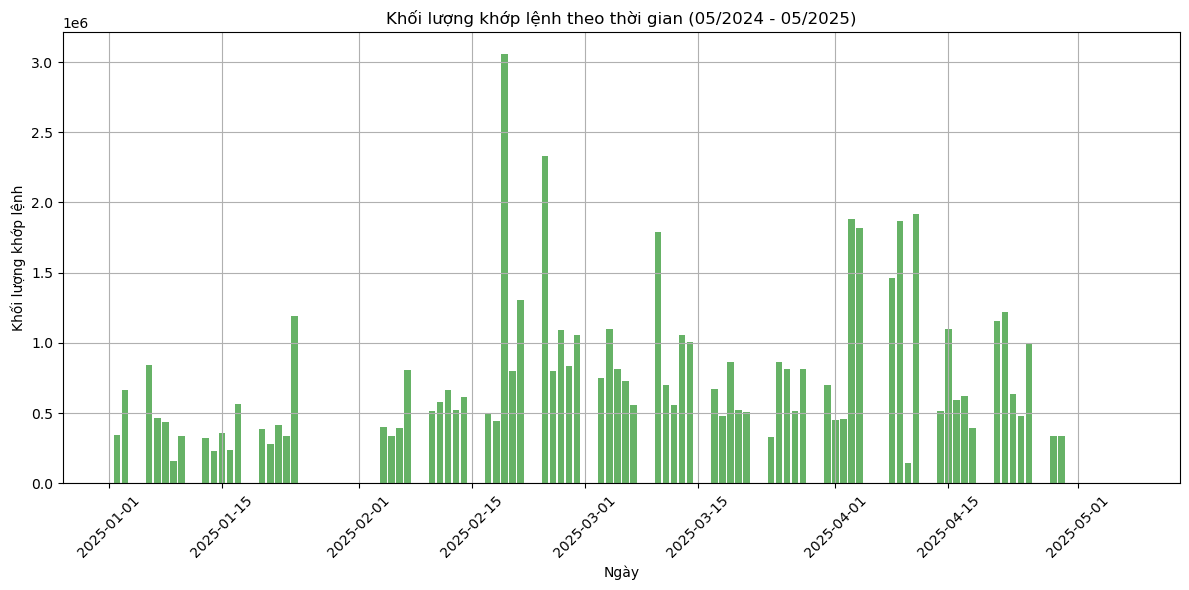

In [50]:
plt.figure(figsize=(12, 6))
plt.bar(recent_data['Ngày'], recent_data['Khối lượng khớp lệnh'], color='green', alpha=0.6)
plt.title('Khối lượng khớp lệnh theo thời gian (05/2024 - 05/2025)')
plt.xlabel('Ngày')
plt.ylabel('Khối lượng khớp lệnh')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

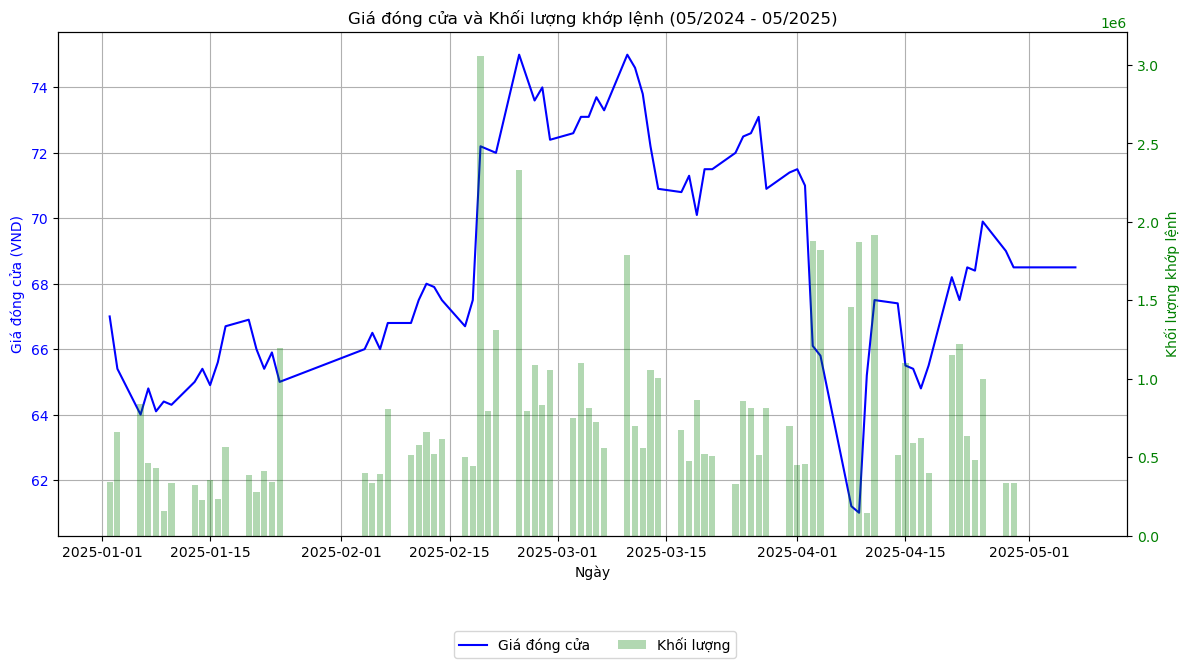

In [52]:
# Vẽ biểu đồ kết hợp giá đóng cửa và khối lượng
fig, ax1 = plt.subplots(figsize=(12, 6))

# Vẽ giá đóng cửa
ax1.plot(recent_data['Ngày'], recent_data['Giá đóng cửa'], color='blue', label='Giá đóng cửa')
ax1.set_xlabel('Ngày')
ax1.set_ylabel('Giá đóng cửa (VND)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid()

# Tạo trục y thứ hai cho khối lượng
ax2 = ax1.twinx()
ax2.bar(recent_data['Ngày'], recent_data['Khối lượng khớp lệnh'], color='green', alpha=0.3, label='Khối lượng')
ax2.set_ylabel('Khối lượng khớp lệnh', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Tiêu đề và xoay nhãn
plt.title('Giá đóng cửa và Khối lượng khớp lệnh (05/2024 - 05/2025)')
fig.tight_layout()
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.xticks(rotation=45)
plt.show()

### 10. Biểu đồ nhiệt giá đóng cửa trung bình theo năm và tháng (2000-2025)

In [53]:
import plotly.express as px
# Tạo cột năm và tháng
data['Năm'] = data['Ngày'].dt.year
data['Tháng'] = data['Ngày'].dt.month

# Tính giá đóng cửa trung bình theo năm và tháng
heatmap_data = data.pivot_table(values='Giá đóng cửa', index='Năm', columns='Tháng', aggfunc='mean')

# Vẽ biểu đồ nhiệt
fig = px.imshow(heatmap_data, 
                labels=dict(x='Tháng', y='Năm', color='Giá đóng cửa (VND)'),
                title='Biểu đồ nhiệt giá đóng cửa trung bình theo năm và tháng (2000-2025)',
                color_continuous_scale='Viridis')

fig.update_layout(
    xaxis_title='Tháng',
    yaxis_title='Năm'
)
fig.show()

In [56]:
# Vẽ biểu đồ tổng hợp
fig = go.Figure()

# Thêm giá đóng cửa
fig.add_trace(go.Scatter(
    x=recent_data['Ngày'], 
    y=recent_data['Giá đóng cửa'],
    mode='lines',
    name='Giá đóng cửa',
    line=dict(color='#1f77b4', width=2)
))

# Thêm MA50
fig.add_trace(go.Scatter(
    x=recent_data['Ngày'], 
    y=recent_data['MA50'],
    mode='lines',
    name='MA50 (Trung bình 50 ngày)',
    line=dict(color='#ff7f0e', width=2)
))

# Thêm MA200
fig.add_trace(go.Scatter(
    x=recent_data['Ngày'], 
    y=recent_data['MA200'],
    mode='lines',
    name='MA200 (Trung bình 200 ngày)',
    line=dict(color='#9467bd', width=2)
))

fig.update_layout(
    title='Giá cổ phiếu REE và Trung bình động (05/2024 - 05/2025)',
    xaxis_title='Ngày',
    yaxis_title='Giá (nghìn đồng)',
    xaxis_rangeslider_visible=True,
    template='plotly_white',
    hovermode='x unified',
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',
    font=dict(size=14)
)

fig.show()

In [58]:
def calculate_rsi(data, periods=14):
    delta = data['Giá đóng cửa'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

recent_data['RSI'] = calculate_rsi(recent_data)

fig = px.line(recent_data, x='Ngày', y='RSI', 
              title='Chỉ số RSI của REE (05/2024 - 05/2025)',
              labels={'RSI': 'RSI'},
              template='plotly_white')
fig.add_hline(y=70, line_dash='dash', line_color='red', annotation_text='Quá mua')
fig.add_hline(y=30, line_dash='dash', line_color='green', annotation_text='Quá bán')
fig.update_layout(font=dict(size=14))
fig.show()

C:\Users\LEGION\AppData\Local\Temp\ipykernel_2272\1491279815.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [62]:
data.to_csv('d:\\IT_HCMUTE\\Hoc_ki_6\\BIG_DATA\\BIGDATA_PROJECT\\Data\\ree_sorted.csv', index=False)